In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve, auc

2024-08-15 11:50:43.935560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 11:50:43.935655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 11:50:44.093964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV files
train_df = pd.read_csv('/kaggle/input/icts-dataset/ICTS_DATASET_CROPPED/train_final.csv')
test_df = pd.read_csv('/kaggle/input/icts-dataset/ICTS_DATASET_CROPPED/test_final.csv')

# Convert class labels to strings
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Balance the dataset by oversampling the minority classes
class_counts = train_df['class'].value_counts()
max_class_count = class_counts.max()

balanced_train_df = train_df.copy()
for class_label in class_counts[class_counts < max_class_count].index:
    class_df = train_df[train_df['class'] == class_label]
    oversampled_class_df = class_df.sample(max_class_count, replace=True)
    balanced_train_df = pd.concat([balanced_train_df, oversampled_class_df], axis=0)




In [3]:
# Split the balanced training data into training and validation sets
train_df, val_df = train_test_split(balanced_train_df, test_size=0.2, stratify=balanced_train_df['class'])


In [4]:
# Directories for train and test images
train_image_dir = '/kaggle/input/icts-dataset/ICTS_DATASET_CROPPED/images/train'
test_image_dir = '/kaggle/input/icts-dataset/ICTS_DATASET_CROPPED/images/test'

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_image_dir,  # Use the same directory as training data
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)



Found 25294 validated image filenames belonging to 17 classes.
Found 6324 validated image filenames belonging to 17 classes.
Found 1968 validated image filenames belonging to 17 classes.


In [5]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights_dict = dict(enumerate(class_weights))

# Create the model
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

# VGG16 model
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)
vgg16_output = Flatten()(vgg16_base.output)

# ResNet50 model
resnet_base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)
resnet_output = Flatten()(resnet_base.output)

# Concatenate the outputs
combined_output = concatenate([vgg16_output, resnet_output])

# Add a fully connected layer
fc_layer = Dense(256, activation='relu')(combined_output)

# Add a final softmax layer
output_layer = Dense(num_classes, activation='softmax')(fc_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)



Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722947428.494637      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722947428.601359      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.6949 - loss: 0.9869

W0000 00:00:1722948060.830678      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 864s 892ms/step - accuracy: 0.6951 - loss: 0.9862 - val_accuracy: 0.7423 - val_loss: 0.8772 - learning_rate: 1.0000e-05
Epoch 2/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 605s 760ms/step - accuracy: 0.9580 - loss: 0.0983 - val_accuracy: 0.9891 - val_loss: 0.0285 - learning_rate: 1.0000e-05
Epoch 3/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 605s 761ms/step - accuracy: 0.9791 - loss: 0.0527 - val_accuracy: 0.9945 - val_loss: 0.0129 - learning_rate: 1.0000e-05
Epoch 4/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 597s 751ms/step - accuracy: 0.9852 - loss: 0.0369 - val_accuracy: 0.9949 - val_loss: 0.0145 - learning_rate: 1.0000e-05
Epoch 5/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 596s 750ms/step - accuracy: 0.9912 - loss: 0.0222 - val_accuracy: 0.9949 - val_loss: 0.0187 - learning_rate: 1.0000e-05
Epoch 6/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 605s 760ms/step - accuracy: 0.9915 - loss: 0.0240 - val_accuracy: 0.9975 - val_loss: 0.0081 - learning_rate: 1.0000e-05
Epoch 7/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 604s 760ms/

In [10]:
# Load the best model
best_model = load_model('best_model.keras')

# Predict the test set
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)



 1/62 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step

W0000 00:00:1722953576.104376      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 676ms/step
Confusion Matrix:
 [[404   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 134   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  83   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 102   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  87   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 173   0   0   2   0]
 [  0   0   0   

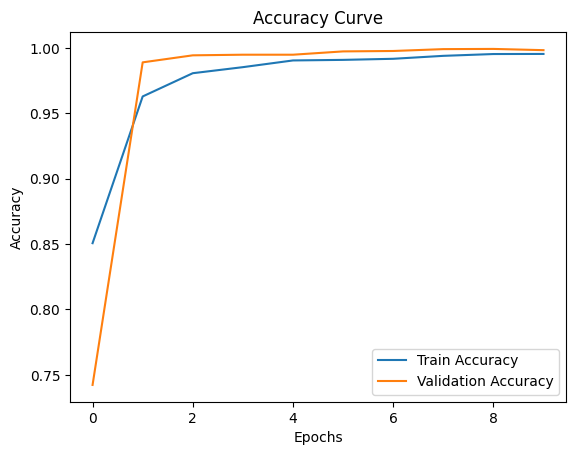

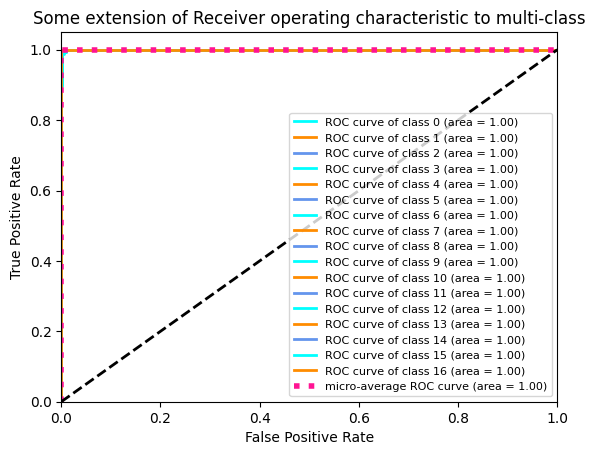

In [11]:
# Plot accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# ROC Curve for Classes

# Binarize the output
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred_classes, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize=8)
plt.show()


In [12]:
# Calculate sensitivity and specificity for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print results for each class
for i, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}:")
    print(f"  Sensitivity: {sensitivity[i]:.4f}")
    print(f"  Specificity: {specificity[i]:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print()

# Calculate macro-average sensitivity and specificity
macro_sensitivity = np.mean(sensitivity)
macro_specificity = np.mean(specificity)
print("Macro-average Sensitivity:", macro_sensitivity)
print("Macro-average Specificity:", macro_specificity)

Class 1:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 10:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 11:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 12:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 13:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 14:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 15:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 16:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 17:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 2:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 3:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 4:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9970

Class 5:
  Sensitivity: 0.9886
  Specificity: 0.9989
  Accuracy: 0.9970

Class 6:
  Sensitivity: 1.0000
  Specificit

In [6]:
# Compile and train the VGG16 model individually
vgg16_model = Model(inputs=vgg16_base.input, outputs=Dense(num_classes, activation='softmax')(vgg16_output))
vgg16_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('vgg16_best_model.keras', monitor='val_loss', save_best_only=True)
    ]
)



Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723722764.242342      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723722764.269288      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


614/791 ━━━━━━━━━━━━━━━━━━━━ 1:13 413ms/step - accuracy: 0.5249 - loss: 1.5152

W0000 00:00:1723723058.249348      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5778 - loss: 1.3412

W0000 00:00:1723723132.127426      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 472s 498ms/step - accuracy: 0.5780 - loss: 1.3404 - val_accuracy: 0.9324 - val_loss: 0.1667 - learning_rate: 1.0000e-05
Epoch 2/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 338s 423ms/step - accuracy: 0.9301 - loss: 0.1897 - val_accuracy: 0.9665 - val_loss: 0.0936 - learning_rate: 1.0000e-05
Epoch 3/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 338s 424ms/step - accuracy: 0.9544 - loss: 0.1221 - val_accuracy: 0.9715 - val_loss: 0.0831 - learning_rate: 1.0000e-05
Epoch 4/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 337s 423ms/step - accuracy: 0.9631 - loss: 0.0941 - val_accuracy: 0.9639 - val_loss: 0.1012 - learning_rate: 1.0000e-05
Epoch 5/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 338s 424ms/step - accuracy: 0.9736 - loss: 0.0702 - val_accuracy: 0.9700 - val_loss: 0.0797 - learning_rate: 1.0000e-05
Epoch 6/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 338s 423ms/step - accuracy: 0.9792 - loss: 0.0546 - val_accuracy: 0.9624 - val_loss: 0.0914 - learning_rate: 1.0000e-05
Epoch 7/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 339s 425ms/

In [7]:
# Compile and train the ResNet50 model individually
resnet50_model = Model(inputs=resnet_base.input, outputs=Dense(num_classes, activation='softmax')(resnet_output))
resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 415s 431ms/step - accuracy: 0.5665 - loss: 1.6228 - val_accuracy: 0.7678 - val_loss: 0.7556 - learning_rate: 1.0000e-05
Epoch 2/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 304s 380ms/step - accuracy: 0.9360 - loss: 0.1770 - val_accuracy: 0.9619 - val_loss: 0.1109 - learning_rate: 1.0000e-05
Epoch 3/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 302s 379ms/step - accuracy: 0.9664 - loss: 0.0937 - val_accuracy: 0.9746 - val_loss: 0.0607 - learning_rate: 1.0000e-05
Epoch 4/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 305s 383ms/step - accuracy: 0.9774 - loss: 0.0610 - val_accuracy: 0.9817 - val_loss: 0.0585 - learning_rate: 1.0000e-05
Epoch 5/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 301s 377ms/step - accuracy: 0.9844 - loss: 0.0443 - val_accuracy: 0.9888 - val_loss: 0.0327 - learning_rate: 1.0000e-05
Epoch 6/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 303s 380ms/step - accuracy: 0.9893 - loss: 0.0301 - val_accuracy: 0.9842 - val_loss: 0.0494 - learning_rate: 1.0000e-05
Epoch 7/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:


# Load the best VGG16 model
vgg16_best_model = load_model('vgg16_best_model.keras')

# Predict the test set using the VGG16 model
vgg16_y_pred = vgg16_best_model.predict(test_generator)
vgg16_y_pred_classes = np.argmax(vgg16_y_pred, axis=1)
vgg16_y_true = test_generator.classes

# Generate confusion matrix for VGG16
vgg16_conf_matrix = confusion_matrix(vgg16_y_true, vgg16_y_pred_classes)

# Calculate overall accuracy for VGG16
vgg16_accuracy = accuracy_score(vgg16_y_true, vgg16_y_pred_classes)

# Calculate precision, recall, and F1-score for each class
vgg16_precision = precision_score(vgg16_y_true, vgg16_y_pred_classes, average='weighted')
vgg16_recall = recall_score(vgg16_y_true, vgg16_y_pred_classes, average='weighted')
vgg16_f1 = f1_score(vgg16_y_true, vgg16_y_pred_classes, average='weighted')

# Calculate sensitivity and specificity for each class
vgg16_TP = np.diag(vgg16_conf_matrix)
vgg16_FP = np.sum(vgg16_conf_matrix, axis=0) - vgg16_TP
vgg16_FN = np.sum(vgg16_conf_matrix, axis=1) - vgg16_TP
vgg16_TN = np.sum(vgg16_conf_matrix) - (vgg16_TP + vgg16_FP + vgg16_FN)

vgg16_sensitivity = np.mean(vgg16_TP / (vgg16_TP + vgg16_FN))
vgg16_specificity = np.mean(vgg16_TN / (vgg16_TN + vgg16_FP))

# Print averaged results
print(f"VGG16 Accuracy: {vgg16_accuracy:.4f}")
print(f"VGG16 Precision (Weighted): {vgg16_precision:.4f}")
print(f"VGG16 Recall (Weighted): {vgg16_recall:.4f}")
print(f"VGG16 F1-score (Weighted): {vgg16_f1:.4f}")
print(f"VGG16 Sensitivity (Average): {vgg16_sensitivity:.4f}")
print(f"VGG16 Specificity (Average): {vgg16_specificity:.4f}")





62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step
VGG16 Accuracy: 0.9924
VGG16 Precision (Weighted): 0.9924
VGG16 Recall (Weighted): 0.9924
VGG16 F1-score (Weighted): 0.9924
VGG16 Sensitivity (Average): 0.9930
VGG16 Specificity (Average): 0.9995


In [9]:
# Load the best ResNet50 model
resnet50_best_model = load_model('resnet50_best_model.keras')

# Predict the test set using the ResNet50 model
resnet50_y_pred = resnet50_best_model.predict(test_generator)
resnet50_y_pred_classes = np.argmax(resnet50_y_pred, axis=1)
resnet50_y_true = test_generator.classes

# Generate confusion matrix for ResNet50
resnet50_conf_matrix = confusion_matrix(resnet50_y_true, resnet50_y_pred_classes)

# Calculate overall accuracy for ResNet50
resnet50_accuracy = accuracy_score(resnet50_y_true, resnet50_y_pred_classes)

# Calculate precision, recall, and F1-score for each class
resnet50_precision = precision_score(resnet50_y_true, resnet50_y_pred_classes, average='weighted')
resnet50_recall = recall_score(resnet50_y_true, resnet50_y_pred_classes, average='weighted')
resnet50_f1 = f1_score(resnet50_y_true, resnet50_y_pred_classes, average='weighted')

# Calculate sensitivity and specificity for each class
resnet50_TP = np.diag(resnet50_conf_matrix)
resnet50_FP = np.sum(resnet50_conf_matrix, axis=0) - resnet50_TP
resnet50_FN = np.sum(resnet50_conf_matrix, axis=1) - resnet50_TP
resnet50_TN = np.sum(resnet50_conf_matrix) - (resnet50_TP + resnet50_FP + resnet50_FN)

resnet50_sensitivity = np.mean(resnet50_TP / (resnet50_TP + resnet50_FN))
resnet50_specificity = np.mean(resnet50_TN / (resnet50_TN + resnet50_FP))

# Print averaged results
print(f"ResNet50 Accuracy: {resnet50_accuracy:.4f}")
print(f"ResNet50 Precision (Weighted): {resnet50_precision:.4f}")
print(f"ResNet50 Recall (Weighted): {resnet50_recall:.4f}")
print(f"ResNet50 F1-score (Weighted): {resnet50_f1:.4f}")
print(f"ResNet50 Sensitivity (Average): {resnet50_sensitivity:.4f}")
print(f"ResNet50 Specificity (Average): {resnet50_specificity:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step
ResNet50 Accuracy: 0.9954
ResNet50 Precision (Weighted): 0.9955
ResNet50 Recall (Weighted): 0.9954
ResNet50 F1-score (Weighted): 0.9954
ResNet50 Sensitivity (Average): 0.9960
ResNet50 Specificity (Average): 0.9997
